In [54]:
import re
import datetime
import requests
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from collections import Counter, defaultdict

In [55]:
URL = "https://remoteok.com/remote-dev-jobs"   # change if you want another RemoteOK page
HEADERS = {"User-Agent": "Mozilla/5.0"}
TOP_N_SKILLS = 15
TOP_LOCATIONS = 6
pd.set_option('display.max_colwidth', 300)

In [56]:
# ---------- Fetch page ----------
resp = requests.get(URL, headers=HEADERS, timeout=20)
print("HTTP status:", resp.status_code)
if resp.status_code != 200:
    raise SystemExit("Failed to fetch page — check URL or network.")
soup = BeautifulSoup(resp.text, "html.parser")

HTTP status: 200


In [57]:
# quick check
job_nodes = soup.find_all("tr", class_="job")
print("Job rows found (static HTML):", len(job_nodes))
if len(job_nodes) == 0:
    raise SystemExit("No job rows found in static HTML. The page may be JS-driven.")

Job rows found (static HTML): 20


In [58]:

# ---------- Parsing loop with robust skill extraction ----------
jobs = []
for job in job_nodes:
    # title, company, location, date
    title = job.find("h2").get_text(strip=True) if job.find("h2") else None
    company = job.find("h3").get_text(strip=True) if job.find("h3") else None
    loc_tag = job.find("div", class_="location") or job.find("span", class_="location")
    location = loc_tag.get_text(strip=True) if loc_tag else "Remote"
    date = None
    if job.find("time") and job.find("time").has_attr("datetime"):
        date = job.find("time")["datetime"]
    elif job.has_attr("data-epoch"):
        try:
            epoch = int(job["data-epoch"])
            date = datetime.datetime.utcfromtimestamp(epoch).isoformat()
        except:
            date = None

    # SKILLS extraction: try HTML tags first, then attributes, with fallback cleaning
    skills = [t.get_text(strip=True) for t in job.select("a.tag")]  # common case
    if not skills:
        # try various data-attributes that sometimes contain tags
        for attr in ("data-stack", "data-search", "data-tags", "data-skill"):
            if job.has_attr(attr) and job[attr]:
                raw = job[attr]
                # remove typical bracket/quote chars and split by comma
                # handle both quoted JSON-like and broken lists
                raw_clean = re.sub(r'^\s*[\[\(]\s*', '', raw)      # leading [ or (
                raw_clean = re.sub(r'[\]\)"]\s*$', '', raw_clean)  # trailing ] ) or "
                # extract quoted tokens first (if any)
                found = re.findall(r'"([^"]+)"', raw)
                if not found:
                    # fallback split by comma and strip quotes/whitespace
                    parts = re.split(r',\s*', raw_clean)
                    parts = [p.strip().strip('"').strip("'") for p in parts if p.strip()]
                    found = parts
                if found:
                    skills = [p for p in found if p and p.strip()]
                    break
    if not skills:
        # final fallback: any anchors in a 'tags' cell
        tags_container = job.select_one("td.tags") or job
        skills = [a.get_text(strip=True) for a in tags_container.find_all("a") if a.get_text(strip=True)]

    skills = [s for s in (skill.strip() for skill in skills) if s]
    jobs.append({
        "Job Title": title,
        "Company": company,
        "Location": location,
        "Skills": ", ".join(skills),
        "Posted Date": date
    })

df = pd.DataFrame(jobs)
print("Parsed rows:", len(df))
display(df.head(10))
                

Parsed rows: 20


,Job Title,Company,Location,Skills,Posted Date
0,Senior Python Backend Engineer,Orga AI,🌏 Worldwide,Orga AI Senior Python Backend Engineer [,2025-07-26T00:00:07+00:00
1,Principal Software Engineer,CEF.Ai,🇪🇺 Europe,CEF.Ai Principal Software Engineer [,2025-07-29T13:16:27+00:00
2,WordPress Plugins & Themes developer,Melapress,🇪🇺 Europe,Melapress WordPress Plugins & Themes developer [,2025-07-22T09:40:58+00:00
3,Software engineer,Sticker Mule,💰 $140k - $180k,Sticker Mule Software engineer [,2025-07-28T09:46:06+00:00
4,Web Developer,MailerLite,🌏 Worldwide,MailerLite Web Developer [,2025-07-25T05:27:01+00:00
5,Senior Fullstack Developer,Swipe Games,🌏 Worldwide,Swipe Games Senior Fullstack Developer {,2025-07-24T00:00:06+00:00
6,Software Engineer Data Infrastructure & Acquisition,Speechify,🌏 Worldwide,Speechify Software Engineer Data Infrastructure & Acquisition [,2025-07-23T12:07:09+00:00
7,Content Producer Technical Content Engineer Junior Dev,Private.Ki,🌏 Worldwide,Private.Ki Content Producer Technical Content Engineer Junior Dev [,2025-07-21T03:24:56+00:00
8,Senior Full Stack Engineer,AMK Solutions,🌏 Worldwide,AMK Solutions Senior Full Stack Engineer [,2025-07-19T00:00:06+00:00
9,Backend Developer @ lobstr.io Python Scraping Celery,lobstr.io,🌏 Worldwide,lobstr.io Backend Developer @ lobstr.io Python Scraping Celery [,2025-07-11T14:43:16+00:00


In [59]:
# ---------- Quick check on Skills column ----------
print("\nSample Skills values (first 20):")
print(df['Skills'].head(20).tolist())
print("Non-empty Skills count:", df['Skills'].astype(bool).sum(), "/", len(df))


Sample Skills values (first 20):
['Orga AI Senior Python Backend Engineer [', 'CEF.Ai Principal Software Engineer [', 'Melapress WordPress Plugins & Themes developer [', 'Sticker Mule Software engineer [', 'MailerLite Web Developer [', 'Swipe Games Senior Fullstack Developer {', 'Speechify Software Engineer Data Infrastructure & Acquisition [', 'Private.Ki Content Producer Technical Content Engineer Junior Dev [', 'AMK Solutions Senior Full Stack Engineer [', 'lobstr.io Backend Developer @ lobstr.io Python Scraping Celery [', 'Lumenalta Javascript Fullstack Engineer Senior [', 'HockeyStack Senior Backend Engineer [', 'Founders Factory Tech Cofounder CTO [', 'Nami ML Senior React Native SDK Engineer {', 'Payara Spanish Speaking Software Support Engineer [', 'Prime Design & Build Administrative Executive [', 'Emergent Software Senior Software Engineer [', 'Incyte Studios Full Stack Developer [', 'Interaction Design Foundation Senior PHP Laravel Developer Full Stack [', 'labs ai spoke pe

In [60]:
# ---------- Normalize skill tokens ----------
def normalize_skill_token(token):
    synonyms = {
        'py': 'python', 'python3': 'python',
        'reactjs': 'react', 'react.js': 'react',
        'nodejs': 'node', 'node.js': 'node',
        'aws lambda': 'aws', 'amazon web services': 'aws'
    }
    t = token.lower().strip()
    t = re.sub(r'[^\w\s\-\+\.#]', '', t)   # keep letters, numbers, -, +, ., #
    t = t.replace('_', ' ').strip()
    return synonyms.get(t, t)

all_tokens = []
for s in df['Skills'].dropna():
    if s.strip():
        parts = [p.strip() for p in re.split(r'[,\|;/]+', s) if p.strip()]
        for p in parts:
            norm = normalize_skill_token(p)
            if norm:
                all_tokens.append(norm)

print("\nNormalized tokens sample:", all_tokens[:30])
if not all_tokens:
    raise SystemExit("No skill tokens parsed — inspect the sample job HTML and adjust selectors.")


Normalized tokens sample: ['orga ai senior python backend engineer', 'cef.ai principal software engineer', 'melapress wordpress plugins  themes developer', 'sticker mule software engineer', 'mailerlite web developer', 'swipe games senior fullstack developer', 'speechify software engineer data infrastructure  acquisition', 'private.ki content producer technical content engineer junior dev', 'amk solutions senior full stack engineer', 'lobstr.io backend developer  lobstr.io python scraping celery', 'lumenalta javascript fullstack engineer senior', 'hockeystack senior backend engineer', 'founders factory tech cofounder cto', 'nami ml senior react native sdk engineer', 'payara spanish speaking software support engineer', 'prime design  build administrative executive', 'emergent software senior software engineer', 'incyte studios full stack developer', 'interaction design foundation senior php laravel developer full stack', 'labs ai spoke person']


,Skill,Count
0,orga ai senior python backend engineer,1
1,cef.ai principal software engineer,1
2,melapress wordpress plugins themes developer,1
3,sticker mule software engineer,1
4,mailerlite web developer,1
5,swipe games senior fullstack developer,1
6,speechify software engineer data infrastructure acquisition,1
7,private.ki content producer technical content engineer junior dev,1
8,amk solutions senior full stack engineer,1
9,lobstr.io backend developer lobstr.io python scraping celery,1


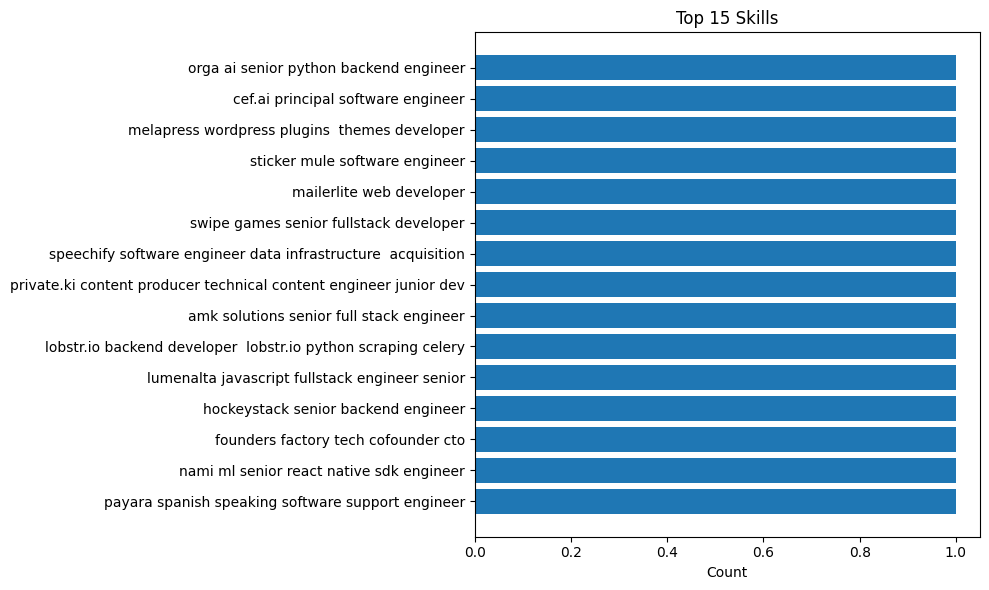

In [61]:
# ---------- Top skills overall (plot) ----------
skill_counts = Counter(all_tokens).most_common(TOP_N_SKILLS)
skill_df = pd.DataFrame(skill_counts, columns=['Skill','Count'])
display(skill_df)

plt.figure(figsize=(10,6))
plt.barh(skill_df['Skill'], skill_df['Count'])
plt.gca().invert_yaxis()
plt.title(f"Top {len(skill_df)} Skills")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

# ---------- Top skills by location (bar chart for top locations
df['Loc_Norm'] = df['Location'].fillna('Remote').apply(lambda x: x.split(',')[0].strip())
loc_job_counts = df['Loc_Norm'].value_counts().nlargest(TOP_LOCATIONS)
top_locs = loc_job_counts.index.tolist()

In [62]:
# build counters
loc_skill_counters = defaultdict(Counter)
for _, row in df.iterrows():
    loc = row['Loc_Norm']
    if row['Skills'] and row['Skills'].strip():
        for p in [pp.strip() for pp in re.split(r'[,\|;/]+', row['Skills']) if pp.strip()]:
            norm = normalize_skill_token(p)
            if norm:
                loc_skill_counters[loc].update([norm])

,Location,Skill,Count
0,🌏 Worldwide,orga ai senior python backend engineer,1
1,🌏 Worldwide,mailerlite web developer,1
2,🌏 Worldwide,swipe games senior fullstack developer,1
3,🌏 Worldwide,speechify software engineer data infrastructure acquisition,1
4,🇪🇺 Europe,cef.ai principal software engineer,1
5,🇪🇺 Europe,melapress wordpress plugins themes developer,1
6,🇪🇺 Europe,founders factory tech cofounder cto,1
7,💰 $140k - $180k,sticker mule software engineer,1
8,💃 Latin America,prime design build administrative executive,1
9,🌏 Probably worldwide,emergent software senior software engineer,1


C:\Users\Hasnain Arain\AppData\Local\Temp\ipykernel_11280\3211926596.py:14: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Hasnain Arain\AppData\Local\Temp\ipykernel_11280\3211926596.py:14: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Hasnain Arain\AppData\Local\Temp\ipykernel_11280\3211926596.py:14: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Hasnain Arain\AppData\Local\Temp\ipykernel_11280\3211926596.py:14: UserWarning: Glyph 127759 (\N{EARTH GLOBE ASIA-AUSTRALIA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Hasnain Arain\AppData\Local\Temp\ipykernel_11280\3211926596.py:14: UserWarning: Glyph 128131 (\N{DANCER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
Font 'default' does not have a glyph for '\U00

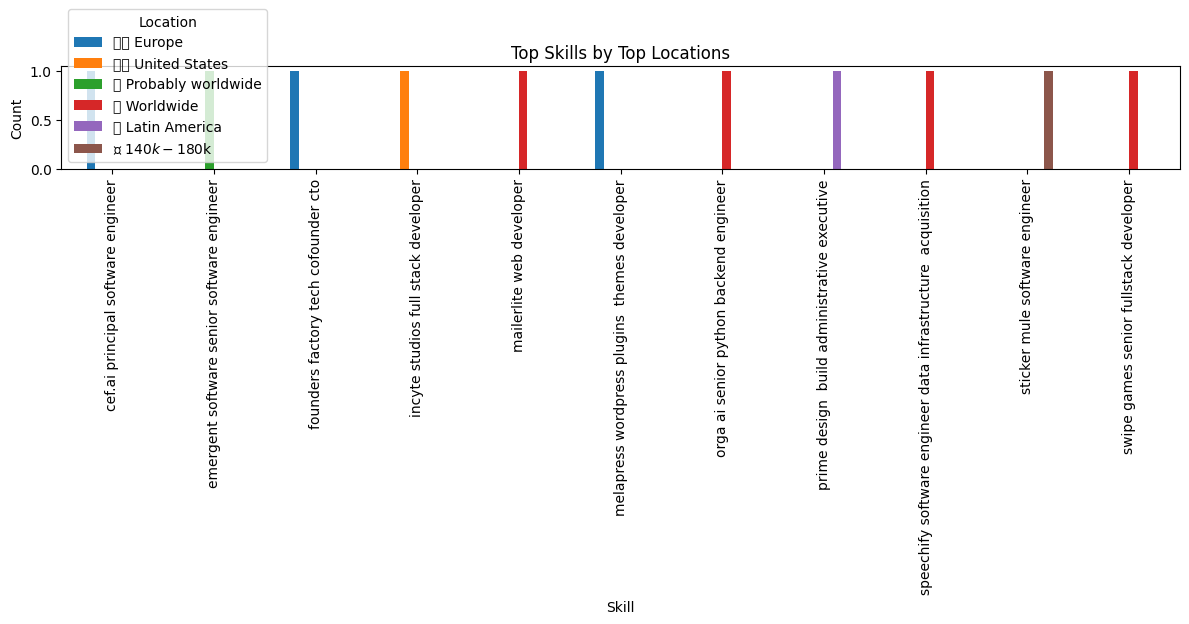

In [63]:
#top 4 skills per top location
rows = []
for loc in top_locs:
    for skill, cnt in loc_skill_counters[loc].most_common(4):
        rows.append({'Location': loc, 'Skill': skill, 'Count': cnt})

if rows:
    loc_df = pd.DataFrame(rows)
    pivot = loc_df.pivot(index='Skill', columns='Location', values='Count').fillna(0)
    display(loc_df)
    ax = pivot.plot(kind='bar', figsize=(12,6))
    ax.set_title("Top Skills by Top Locations")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("No location-skill pairs to plot.")